In [5]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1" 
import torch
torch.cuda.device_count()

1

In [6]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from glob import glob
# import wandb

import monai
from monai.losses import DiceCELoss, DiceFocalLoss, FocalLoss
from monai.inferers import sliding_window_inference
from monai import transforms

from monai.transforms import (
    AsDiscrete,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    MapTransform,
    ScaleIntensityd,
    #AddChanneld,
    SpatialPadd,
    CenterSpatialCropd,
    EnsureChannelFirstd,
    ConcatItemsd,
    AdjustContrastd, 
    Rand3DElasticd,
    HistogramNormalized,
    NormalizeIntensityd,
    Invertd,
    SaveImage,

)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import SwinUNETR, UNETR, SegResNet

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)
from monai import data


from monai.utils import first, set_determinism
from sklearn.model_selection import train_test_split
import json


import torch

In [7]:
set_determinism(seed=1024)

In [8]:
import os
import json
import random
from glob import glob

def generate_paths(patient_id):
    base_dir = '/home/nada.saadi/MIS-FM/hecktor2022_cropped/data'
    return {
        'id': os.path.join(base_dir, patient_id),
        'ct': os.path.join(base_dir, patient_id, f"{patient_id}_ct.nii.gz"),
        'seg': os.path.join(base_dir, patient_id, f"{patient_id}_gt.nii.gz")
    }

# Assign each data entry to a random fold
all_data = []
num_folds = 5

for file_dir in sorted(glob('data/*')):
    patient_id = file_dir.split('/')[-1]
    # Check if the file belongs to the MDA center
    if patient_id.startswith("MDA-"):
        entry = generate_paths(patient_id)
        entry['fold'] = random.randint(1, num_folds) - 1
        all_data.append(entry)

# Compile data into a JSON structure
data_json = {"training": all_data}

# Save to JSON file
json_file_path = "/home/nada.saadi/MIS-FM/hecktor2022_cropped/MDA_ct_train_new.json"
with open(json_file_path, 'w') as f:
    json.dump(data_json, f, indent=4)

print(f"JSON file created at {json_file_path}")



JSON file created at /home/nada.saadi/MIS-FM/hecktor2022_cropped/MDA_ct_train_new.json


In [9]:
data_dir = '/home/nada.saadi/MIS-FM/hecktor2022_cropped'
json_dir = '/home/nada.saadi/MIS-FM/hecktor2022_cropped/MDA_ct_train_new.json'

In [10]:
def datafold_read(datalist, basedir, fold=0, key="training"):
    with open(datalist) as f:
        json_data = json.load(f)

    json_data = json_data[key]

    for d in json_data:
        for k in d:
            if isinstance(d[k], list):
                d[k] = [os.path.join(basedir, iv) for iv in d[k]]
            elif isinstance(d[k], str):
                d[k] = os.path.join(basedir, d[k]) if len(d[k]) > 0 else d[k]

    tr = []
    val = []
    for d in json_data:
        if "fold" in d and d["fold"] == fold:
            val.append(d)
        else:
            tr.append(d)

    return tr, val

In [11]:
train_files, validation_files = datafold_read(datalist=json_dir, basedir=data_dir, fold=0)
len(train_files), len(validation_files)

(152, 44)

/home/nada.saadi/miniconda3/envs/clam/lib/python3.8/site-packages/monai/transforms/spatial/array.py:635: UserWarning: axcodes ('RAS') length is smaller than number of input spatial dimensions D=2.
Orientation: spatial shape = (200, 310), channels = 200,please make sure the input is in the channel-first format.
  warnings.warn(


torch.Size([200, 200, 310])


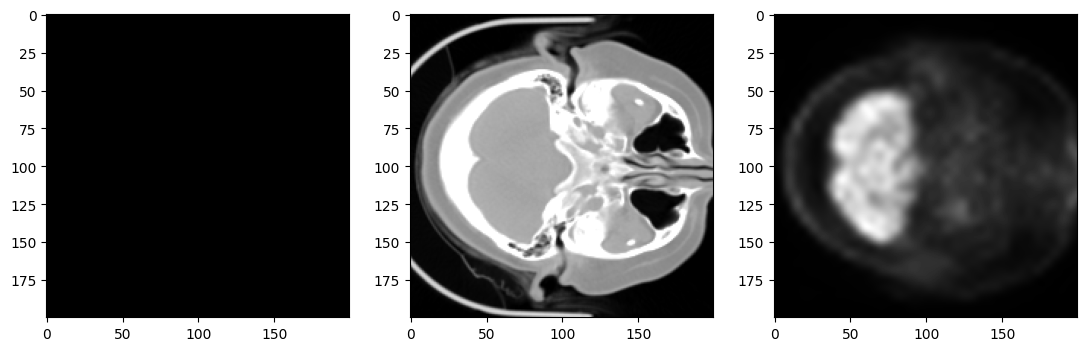

In [12]:
from skimage import measure

slice_num = 133
gt = monai.transforms.LoadImage(ensure_channel_first=True)('data/MDA-201/MDA-201_gt.nii.gz')
plt.figure("image", (18, 10))
gt = monai.transforms.Orientation(axcodes='RAS')(gt[0])
plt.subplot(2, 4, 1)
plt.imshow(gt[:,:,slice_num], cmap='gray')
print(gt.shape)

#contours = measure.find_contours(gt[:,slice_num,:], 0.5)[0]
#plt.plot(contours[:, 1], contours[:, 0], linewidth=0.8, c='red',  alpha = 0.8)

ct = monai.transforms.LoadImage(ensure_channel_first=True)('data/MDA-201/MDA-201_ct.nii.gz')
ct = monai.transforms.Orientation(axcodes='RAS')(ct[0])
ct = torch.clip(ct, min=-1000, max=600)
plt.subplot(2, 4, 2)
plt.imshow(ct[:,:,slice_num], cmap='gray')
#plt.plot(contours[:, 1], contours[:, 0], linewidth=0.8, c='red',  alpha = 0.8)

pt = monai.transforms.LoadImage(ensure_channel_first=True)('data/MDA-201/MDA-201_pt.nii.gz')
pt = monai.transforms.Orientation(axcodes='RAS')(pt[0])
plt.subplot(2, 4, 3)
plt.imshow(pt[:,:,slice_num], cmap='gray')
#plt.plot(contours[:, 1], contours[:, 0], linewidth=0.8, c='red',  alpha = 0.8)

In [13]:
class ClipCT(MapTransform):
    """
    Convert labels to multi channels based on hecktor classes:
    label 1 is the tumor
    label 2 is the lymph node

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            if key == "ct":
                d[key] = torch.clip(d[key], min=-200, max=200)
            # elif key == "pt":
            #     d[key] = torch.clip(d[key], d[key].min(), 5)
        return d

class MulPTFM(MapTransform):
    """
    Mult PT and FM 

    """

    def __call__(self, data):
        d = dict(data)

        fm = d["ct"] > 0
        d["pt"] = d["pt"] * fm
        return d

class SelectClass(MapTransform):
    """
    Select the class for which you want to fine tune the model 

    """
    # def __init__(self, keys, cls=1):
    #     super(self).__init__(keys)
    #     self.cls = cls

    def __call__(self, data):
        d = dict(data)
        d["seg"][d["seg"] == 1] = 0
        # d["seg"][d["seg"] == 2] = 1
        
        return d

In [12]:
num_samples = 4

train_transforms = Compose(
    [
        LoadImaged(keys=["ct", "seg"], ensure_channel_first = True),
        SpatialPadd(keys=["ct",  "seg"], spatial_size=(200, 200, 310), method='end'),
        Orientationd(keys=["ct",  "seg"], axcodes="PLS"),
        #NormalizeIntensityd(keys=["pt"]),
        ClipCT(keys=["ct"]),
        ScaleIntensityd(keys=["ct"], minv=0, maxv=1),
        #MulPTFM(keys=["ct","pt"]),
        #ConcatItemsd(keys=["pt", "ct"], name="ctpt"),
        #NormalizeIntensityd(keys=["ctpt"], channel_wise=True),
        RandCropByPosNegLabeld(
            keys=["ct", "seg"],
            label_key="seg",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=num_samples,
            image_key="ct",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["ct", "seg"],
            spatial_axis=[0],
            prob=0.20,
        ),
        RandFlipd(
            keys=["ct", "seg"],
            spatial_axis=[1],
            prob=0.20,
        ),
        RandFlipd(
            keys=["ct", "seg"],
            spatial_axis=[2],
            prob=0.20,
        ),
        RandRotate90d(
            keys=["ct", "seg"],
            prob=0.20,
            max_k=3,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["ct", "seg"], ensure_channel_first = True),
        SpatialPadd(keys=["ct", "seg"], spatial_size=(200, 200, 310), method='end'),
        Orientationd(keys=["ct",  "seg"], axcodes="PLS"),
        #NormalizeIntensityd(keys=["pt"]),
        ClipCT(keys=["ct"]),
        ScaleIntensityd(keys=["ct"], minv=0, maxv=1),
        #MulPTFM(keys=["ct","pt"]),
        #ConcatItemsd(keys=["pt", "ct"], name="ctpt"),
    ]
)

In [13]:
train_ds = monai.data.Dataset(data=train_files, transform=train_transforms)

train_loader = DataLoader(
    train_ds,
    batch_size=2,
    shuffle=True,
    num_workers=8,
    pin_memory=torch.cuda.is_available(),
    )

val_ds = monai.data.Dataset(data=validation_files, transform=val_transforms)

val_loader = DataLoader(
    val_ds, 
    batch_size=2, 
    num_workers=8, 
    shuffle= False)

In [4]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = SegResNet(in_channels=2, 
#                   out_channels=3, 
#                   init_filters=16).to(device)
      
model = UNETR(
    in_channels=1,
    out_channels=3,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072, 
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)


  # model = SwinUNETR(img_size= (96, 96, 96),
  #                     in_channels=1, #changed from 2 to 1
  #                     out_channels=3,
  #                     depths = (2, 2, 2, 2),
  #                     num_heads = (3, 6, 12, 24),
  #                     feature_size = 24,
  #                     norm_name = "instance",
  #                     drop_rate = 0.0,
  #                   attn_drop_rate = 0.0,
  #                   dropout_path_rate = 0.0,
  #                   normalize = True,
  #                   use_checkpoint = False,
  #                   spatial_dims = 3,
  #                   downsample="merging").to(device)

NameError: name 'os' is not defined

In [15]:
torch.backends.cudnn.benchmark = True
def poly_lr(epoch, max_epochs, initial_lr, exponent=0.9):
    return initial_lr * (1 - epoch / max_epochs)**exponent

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [17]:
model_dir = '/home/nada.saadi/MIS-FM/hecktor2022_cropped/MDA_ct_unetr_files'

def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator_val):
            val_inputs, val_labels = (batch["ct"].cuda(), batch["seg"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [
                post_label(val_label_tensor) for val_label_tensor in val_labels_list
            ]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [
                post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
            ]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            dice_metric_batch(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description(
                "Validate (%d / %d Steps)" % (global_step, 10.0)
            )
        mean_dice_val = dice_metric.aggregate().item()
        metric_batch_val = dice_metric_batch.aggregate()

        metric_tumor = metric_batch_val[0].item()
        metric_lymph = metric_batch_val[1].item()

        dice_metric.reset()
        dice_metric_batch.reset()
    return mean_dice_val, metric_tumor, metric_lymph


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
    )
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["ct"].cuda(), batch["seg"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)"
            % (global_step, max_iterations, loss)
        )
        if (
            global_step % eval_num == 0 and global_step != 0
        ) or global_step == max_iterations:
            epoch_iterator_val = tqdm(
                val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True
            )
            dice_val, metric_tumor, metric_lymph = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            metric_values_tumor.append(metric_tumor)
            metric_values_lymph.append(metric_lymph)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(
                    model.state_dict(), os.path.join(model_dir, "best_mda_metric_unetr.pth")
                )
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {} Current Avg. tumor Dice: {} Current Avg. lymph Dice: {}".format(
                        dice_val_best, dice_val, metric_tumor, metric_lymph
                    )
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {} Current Avg. tumor Dice: {} Current Avg. lymph Dice: {}".format(
                        dice_val_best, dice_val,  metric_tumor, metric_lymph
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 18000
eval_num = 100

post_label = AsDiscrete(to_onehot=3)
post_pred = AsDiscrete(argmax=True, to_onehot=3)

dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
dice_metric_batch = DiceMetric(include_background=False, reduction="mean_batch")

epoch = 0
max_num_epochs = 530

global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
metric_values_tumor = []
metric_values_lymph = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(
        global_step, train_loader, dice_val_best, global_step_best
    )
    # wandb.log({'learning_rate': optimizer.param_groups[0]['lr']})
    # wandb.log({'Best Dice': dice_val_best})
    epoch += 1
    #optimizer.param_groups[0]['lr'] = poly_lr(epoch, max_num_epochs, 0.005676 , 0.9)
# model.load_state_dict(torch.load(os.path.join(model_dir, "best_metric_luck_UNETr_prompt.pth")))

Training (100 / 18000 Steps) (loss=1.10479):  33%|███▎      | 25/76 [00:41<07:29,  8.81s/it]

Model Was Saved ! Current Best Avg. Dice: 2.8196238417876884e-05 Current Avg. Dice: 2.8196238417876884e-05 Current Avg. tumor Dice: 5.907783270231448e-05 Current Avg. lymph Dice: 0.0


Training (200 / 18000 Steps) (loss=1.05016):  64%|██████▍   | 49/76 [00:52<03:54,  8.67s/it]

Model Was Not Saved ! Current Best Avg. Dice: 2.8196238417876884e-05 Current Avg. Dice: 0.0 Current Avg. tumor Dice: 0.0 Current Avg. lymph Dice: 0.0


Training (300 / 18000 Steps) (loss=0.98719):  96%|█████████▌| 73/76 [01:04<00:26,  8.82s/it]

Model Was Saved ! Current Best Avg. Dice: 0.001107988995499909 Current Avg. Dice: 0.001107988995499909 Current Avg. tumor Dice: 0.0 Current Avg. lymph Dice: 0.002708417596295476


Training (400 / 18000 Steps) (loss=0.95728):  28%|██▊       | 21/76 [00:40<08:16,  9.03s/it]

Model Was Saved ! Current Best Avg. Dice: 0.02603275328874588 Current Avg. Dice: 0.02603275328874588 Current Avg. tumor Dice: 0.0 Current Avg. lymph Dice: 0.06362953037023544


Training (500 / 18000 Steps) (loss=0.89364):  59%|█████▉    | 45/76 [00:50<04:36,  8.92s/it]

Model Was Saved ! Current Best Avg. Dice: 0.04531470686197281 Current Avg. Dice: 0.04531470686197281 Current Avg. tumor Dice: 0.0 Current Avg. lymph Dice: 0.11071457713842392


Training (600 / 18000 Steps) (loss=0.87576):  91%|█████████ | 69/76 [01:01<01:01,  8.75s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.04531470686197281 Current Avg. Dice: 0.037505052983760834 Current Avg. tumor Dice: 0.0 Current Avg. lymph Dice: 0.09164983779191971


Training (700 / 18000 Steps) (loss=0.84138):  22%|██▏       | 17/76 [00:38<08:36,  8.76s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.04531470686197281 Current Avg. Dice: 0.041143521666526794 Current Avg. tumor Dice: 0.0 Current Avg. lymph Dice: 0.10057304799556732


Training (800 / 18000 Steps) (loss=0.80902):  54%|█████▍    | 41/76 [00:49<05:12,  8.94s/it]

Model Was Saved ! Current Best Avg. Dice: 0.05679822340607643 Current Avg. Dice: 0.05679822340607643 Current Avg. tumor Dice: 0.0 Current Avg. lymph Dice: 0.13879863917827606


Training (900 / 18000 Steps) (loss=0.81029):  86%|████████▌ | 65/76 [01:00<01:37,  8.85s/it]

Model Was Saved ! Current Best Avg. Dice: 0.08206408470869064 Current Avg. Dice: 0.08206408470869064 Current Avg. tumor Dice: 0.0 Current Avg. lymph Dice: 0.19634093344211578


Training (1000 / 18000 Steps) (loss=0.76099):  17%|█▋        | 13/76 [00:36<09:18,  8.87s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.08206408470869064 Current Avg. Dice: 0.058547213673591614 Current Avg. tumor Dice: 0.0 Current Avg. lymph Dice: 0.14253361523151398


Training (1100 / 18000 Steps) (loss=0.74623):  49%|████▊     | 37/76 [00:46<05:42,  8.79s/it]

Model Was Saved ! Current Best Avg. Dice: 0.08246524631977081 Current Avg. Dice: 0.08246524631977081 Current Avg. tumor Dice: 0.0 Current Avg. lymph Dice: 0.19680476188659668


Training (1200 / 18000 Steps) (loss=0.76819):  80%|████████  | 61/76 [00:58<02:13,  8.91s/it]

Model Was Saved ! Current Best Avg. Dice: 0.1500881463289261 Current Avg. Dice: 0.1500881463289261 Current Avg. tumor Dice: 0.11938092857599258 Current Avg. lymph Dice: 0.19887931644916534


Training (1300 / 18000 Steps) (loss=0.69259):  12%|█▏        | 9/76 [00:34<10:16,  9.20s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.1500881463289261 Current Avg. Dice: 0.1369439959526062 Current Avg. tumor Dice: 0.1079285591840744 Current Avg. lymph Dice: 0.18816937506198883


Training (1400 / 18000 Steps) (loss=0.73229):  43%|████▎     | 33/76 [00:45<06:14,  8.70s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.1500881463289261 Current Avg. Dice: 0.1412367969751358 Current Avg. tumor Dice: 0.1123000755906105 Current Avg. lymph Dice: 0.1928117275238037


Training (1500 / 18000 Steps) (loss=0.70001):  75%|███████▌  | 57/76 [00:57<02:51,  9.03s/it]

Model Was Saved ! Current Best Avg. Dice: 0.16082610189914703 Current Avg. Dice: 0.16082610189914703 Current Avg. tumor Dice: 0.12459772080183029 Current Avg. lymph Dice: 0.22866906225681305


Training (1600 / 18000 Steps) (loss=0.70948):   7%|▋         | 5/76 [00:33<12:50, 10.85s/it]

Model Was Saved ! Current Best Avg. Dice: 0.21376709640026093 Current Avg. Dice: 0.21376709640026093 Current Avg. tumor Dice: 0.18437884747982025 Current Avg. lymph Dice: 0.26011839509010315


Training (1700 / 18000 Steps) (loss=0.67081):  38%|███▊      | 29/76 [00:43<06:48,  8.70s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.21376709640026093 Current Avg. Dice: 0.18586872518062592 Current Avg. tumor Dice: 0.14947490394115448 Current Avg. lymph Dice: 0.2400817573070526


Training (1800 / 18000 Steps) (loss=0.70572):  70%|██████▉   | 53/76 [00:54<03:22,  8.80s/it]

Model Was Saved ! Current Best Avg. Dice: 0.21852250397205353 Current Avg. Dice: 0.21852250397205353 Current Avg. tumor Dice: 0.19978992640972137 Current Avg. lymph Dice: 0.25953757762908936


Training (1900 / 18000 Steps) (loss=0.66657):   1%|▏         | 1/76 [00:30<38:23, 30.71s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.21852250397205353 Current Avg. Dice: 0.15228167176246643 Current Avg. tumor Dice: 0.06953416019678116 Current Avg. lymph Dice: 0.2752071022987366


Training (2000 / 18000 Steps) (loss=0.68785):  33%|███▎      | 25/76 [00:42<07:27,  8.78s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.21852250397205353 Current Avg. Dice: 0.19877123832702637 Current Avg. tumor Dice: 0.15681317448616028 Current Avg. lymph Dice: 0.2671155333518982


Training (2100 / 18000 Steps) (loss=0.63746):  64%|██████▍   | 49/76 [00:53<03:59,  8.86s/it]

Model Was Saved ! Current Best Avg. Dice: 0.22949157655239105 Current Avg. Dice: 0.22949157655239105 Current Avg. tumor Dice: 0.18002746999263763 Current Avg. lymph Dice: 0.31483542919158936


Training (2200 / 18000 Steps) (loss=0.63763):  96%|█████████▌| 73/76 [01:03<00:26,  8.78s/it]

Model Was Saved ! Current Best Avg. Dice: 0.23530513048171997 Current Avg. Dice: 0.23530513048171997 Current Avg. tumor Dice: 0.1955472230911255 Current Avg. lymph Dice: 0.30772829055786133


Training (2300 / 18000 Steps) (loss=0.66969):  28%|██▊       | 21/76 [00:39<07:55,  8.65s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.23530513048171997 Current Avg. Dice: 0.20012488961219788 Current Avg. tumor Dice: 0.21917842328548431 Current Avg. lymph Dice: 0.17792993783950806


Training (2400 / 18000 Steps) (loss=0.66223):  59%|█████▉    | 45/76 [00:51<04:31,  8.75s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.23530513048171997 Current Avg. Dice: 0.2337927222251892 Current Avg. tumor Dice: 0.20318982005119324 Current Avg. lymph Dice: 0.29673343896865845


Training (2500 / 18000 Steps) (loss=0.61316):  91%|█████████ | 69/76 [01:01<01:00,  8.63s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.23530513048171997 Current Avg. Dice: 0.21222534775733948 Current Avg. tumor Dice: 0.13677136600017548 Current Avg. lymph Dice: 0.33327606320381165


Training (2600 / 18000 Steps) (loss=0.61789):  22%|██▏       | 17/76 [00:38<08:46,  8.92s/it]

Model Was Saved ! Current Best Avg. Dice: 0.27452751994132996 Current Avg. Dice: 0.27452751994132996 Current Avg. tumor Dice: 0.25115376710891724 Current Avg. lymph Dice: 0.31266796588897705


Training (2700 / 18000 Steps) (loss=0.58615):  54%|█████▍    | 41/76 [00:50<05:13,  8.95s/it]

Model Was Saved ! Current Best Avg. Dice: 0.2901546359062195 Current Avg. Dice: 0.2901546359062195 Current Avg. tumor Dice: 0.26786381006240845 Current Avg. lymph Dice: 0.33199527859687805


Training (2800 / 18000 Steps) (loss=0.65566):  86%|████████▌ | 65/76 [00:59<01:34,  8.59s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.2901546359062195 Current Avg. Dice: 0.28073742985725403 Current Avg. tumor Dice: 0.2575940489768982 Current Avg. lymph Dice: 0.3268333971500397


Training (2900 / 18000 Steps) (loss=0.60793):  17%|█▋        | 13/76 [00:35<09:12,  8.76s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.2901546359062195 Current Avg. Dice: 0.27459847927093506 Current Avg. tumor Dice: 0.23377414047718048 Current Avg. lymph Dice: 0.3416697680950165


Training (3000 / 18000 Steps) (loss=0.54766):  49%|████▊     | 37/76 [00:48<05:51,  9.01s/it]

Model Was Saved ! Current Best Avg. Dice: 0.29969075322151184 Current Avg. Dice: 0.29969075322151184 Current Avg. tumor Dice: 0.2602713108062744 Current Avg. lymph Dice: 0.36348795890808105


Training (3100 / 18000 Steps) (loss=0.59452):  80%|████████  | 61/76 [00:57<02:10,  8.73s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.29969075322151184 Current Avg. Dice: 0.27591821551322937 Current Avg. tumor Dice: 0.21830937266349792 Current Avg. lymph Dice: 0.3623812198638916


Training (3200 / 18000 Steps) (loss=0.54216):  12%|█▏        | 9/76 [00:34<10:03,  9.01s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.29969075322151184 Current Avg. Dice: 0.27628597617149353 Current Avg. tumor Dice: 0.24327361583709717 Current Avg. lymph Dice: 0.33805105090141296


Training (3300 / 18000 Steps) (loss=0.65203):  43%|████▎     | 33/76 [00:46<06:28,  9.05s/it]

Model Was Saved ! Current Best Avg. Dice: 0.31012892723083496 Current Avg. Dice: 0.31012892723083496 Current Avg. tumor Dice: 0.2758108079433441 Current Avg. lymph Dice: 0.3642790615558624


Training (3400 / 18000 Steps) (loss=0.48396):  75%|███████▌  | 57/76 [00:56<02:47,  8.83s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.31012892723083496 Current Avg. Dice: 0.2670480012893677 Current Avg. tumor Dice: 0.21470798552036285 Current Avg. lymph Dice: 0.35621148347854614


Training (3500 / 18000 Steps) (loss=0.59838):   7%|▋         | 5/76 [00:33<12:49, 10.84s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.31012892723083496 Current Avg. Dice: 0.30794623494148254 Current Avg. tumor Dice: 0.2889234721660614 Current Avg. lymph Dice: 0.3477836549282074


Training (3600 / 18000 Steps) (loss=0.52835):  38%|███▊      | 29/76 [00:43<06:54,  8.81s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.31012892723083496 Current Avg. Dice: 0.29181817173957825 Current Avg. tumor Dice: 0.2320774644613266 Current Avg. lymph Dice: 0.37762418389320374


Training (3700 / 18000 Steps) (loss=0.51075):  70%|██████▉   | 53/76 [00:55<03:27,  9.01s/it]

Model Was Saved ! Current Best Avg. Dice: 0.3226248621940613 Current Avg. Dice: 0.3226248621940613 Current Avg. tumor Dice: 0.28404247760772705 Current Avg. lymph Dice: 0.38990020751953125


Training (3800 / 18000 Steps) (loss=0.60574):   1%|▏         | 1/76 [00:30<38:11, 30.55s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3226248621940613 Current Avg. Dice: 0.2695963680744171 Current Avg. tumor Dice: 0.2553550601005554 Current Avg. lymph Dice: 0.3001411259174347


Training (3900 / 18000 Steps) (loss=0.63965):  33%|███▎      | 25/76 [00:42<07:36,  8.95s/it]

Model Was Saved ! Current Best Avg. Dice: 0.32479339838027954 Current Avg. Dice: 0.32479339838027954 Current Avg. tumor Dice: 0.28851568698883057 Current Avg. lymph Dice: 0.37416350841522217


Training (4000 / 18000 Steps) (loss=0.57889):  64%|██████▍   | 49/76 [00:52<03:52,  8.59s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.32479339838027954 Current Avg. Dice: 0.2904280424118042 Current Avg. tumor Dice: 0.265938937664032 Current Avg. lymph Dice: 0.34006038308143616


Training (4100 / 18000 Steps) (loss=0.53213):  96%|█████████▌| 73/76 [01:04<00:26,  8.72s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.32479339838027954 Current Avg. Dice: 0.31644585728645325 Current Avg. tumor Dice: 0.3121531009674072 Current Avg. lymph Dice: 0.3426310420036316


Training (4200 / 18000 Steps) (loss=0.59182):  28%|██▊       | 21/76 [00:40<08:05,  8.82s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.32479339838027954 Current Avg. Dice: 0.32050198316574097 Current Avg. tumor Dice: 0.29500511288642883 Current Avg. lymph Dice: 0.3676519989967346


Training (4300 / 18000 Steps) (loss=0.55219):  59%|█████▉    | 45/76 [00:51<04:35,  8.89s/it]

Model Was Saved ! Current Best Avg. Dice: 0.3266064524650574 Current Avg. Dice: 0.3266064524650574 Current Avg. tumor Dice: 0.29460132122039795 Current Avg. lymph Dice: 0.3869017958641052


Training (4400 / 18000 Steps) (loss=0.65389):  91%|█████████ | 69/76 [01:02<01:02,  8.91s/it]

Model Was Saved ! Current Best Avg. Dice: 0.33737698197364807 Current Avg. Dice: 0.33737698197364807 Current Avg. tumor Dice: 0.3098410964012146 Current Avg. lymph Dice: 0.3874523639678955


Training (4500 / 18000 Steps) (loss=0.55217):  22%|██▏       | 17/76 [00:38<08:31,  8.67s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.33737698197364807 Current Avg. Dice: 0.30673444271087646 Current Avg. tumor Dice: 0.2670367658138275 Current Avg. lymph Dice: 0.36976194381713867


Training (4600 / 18000 Steps) (loss=0.49933):  54%|█████▍    | 41/76 [00:49<05:12,  8.92s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.33737698197364807 Current Avg. Dice: 0.3241773545742035 Current Avg. tumor Dice: 0.30118459463119507 Current Avg. lymph Dice: 0.3672333061695099


Training (4700 / 18000 Steps) (loss=0.54777):  86%|████████▌ | 65/76 [01:01<01:37,  8.86s/it]

Model Was Saved ! Current Best Avg. Dice: 0.34426185488700867 Current Avg. Dice: 0.34426185488700867 Current Avg. tumor Dice: 0.32000672817230225 Current Avg. lymph Dice: 0.38173484802246094


Training (4800 / 18000 Steps) (loss=0.58049):  17%|█▋        | 13/76 [00:36<09:07,  8.69s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.34426185488700867 Current Avg. Dice: 0.34042301774024963 Current Avg. tumor Dice: 0.31173980236053467 Current Avg. lymph Dice: 0.39312490820884705


Training (4900 / 18000 Steps) (loss=0.57636):  49%|████▊     | 37/76 [00:47<05:45,  8.85s/it]

Model Was Saved ! Current Best Avg. Dice: 0.35534802079200745 Current Avg. Dice: 0.35534802079200745 Current Avg. tumor Dice: 0.34312084317207336 Current Avg. lymph Dice: 0.3808058500289917


Training (5000 / 18000 Steps) (loss=0.57743):  80%|████████  | 61/76 [00:57<02:09,  8.65s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.35534802079200745 Current Avg. Dice: 0.3203538954257965 Current Avg. tumor Dice: 0.29168349504470825 Current Avg. lymph Dice: 0.3734094798564911


Training (5100 / 18000 Steps) (loss=0.65623):  12%|█▏        | 9/76 [00:34<10:07,  9.06s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.35534802079200745 Current Avg. Dice: 0.32777345180511475 Current Avg. tumor Dice: 0.2878512442111969 Current Avg. lymph Dice: 0.39512643218040466


Training (5200 / 18000 Steps) (loss=0.57141):  43%|████▎     | 33/76 [00:45<06:19,  8.84s/it]

Model Was Saved ! Current Best Avg. Dice: 0.35781329870224 Current Avg. Dice: 0.35781329870224 Current Avg. tumor Dice: 0.32609325647354126 Current Avg. lymph Dice: 0.4082062542438507


Training (5300 / 18000 Steps) (loss=0.54104):  75%|███████▌  | 57/76 [00:56<02:43,  8.61s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.35781329870224 Current Avg. Dice: 0.34292757511138916 Current Avg. tumor Dice: 0.302785724401474 Current Avg. lymph Dice: 0.4032207727432251


Training (5400 / 18000 Steps) (loss=0.50552):   7%|▋         | 5/76 [00:31<12:22, 10.46s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.35781329870224 Current Avg. Dice: 0.3265409469604492 Current Avg. tumor Dice: 0.284872829914093 Current Avg. lymph Dice: 0.39859336614608765


Training (5500 / 18000 Steps) (loss=0.45837):  38%|███▊      | 29/76 [00:43<06:47,  8.67s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.35781329870224 Current Avg. Dice: 0.30914410948753357 Current Avg. tumor Dice: 0.2674272954463959 Current Avg. lymph Dice: 0.387765109539032


Training (5600 / 18000 Steps) (loss=0.48321):  70%|██████▉   | 53/76 [00:54<03:17,  8.59s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.35781329870224 Current Avg. Dice: 0.3386094868183136 Current Avg. tumor Dice: 0.2972608208656311 Current Avg. lymph Dice: 0.4112240970134735


Training (5700 / 18000 Steps) (loss=0.52799):   1%|▏         | 1/76 [00:30<38:39, 30.92s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.35781329870224 Current Avg. Dice: 0.338996022939682 Current Avg. tumor Dice: 0.304914653301239 Current Avg. lymph Dice: 0.3991177976131439


Training (5800 / 18000 Steps) (loss=0.50185):  33%|███▎      | 25/76 [00:41<07:24,  8.71s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.35781329870224 Current Avg. Dice: 0.3345378637313843 Current Avg. tumor Dice: 0.32146307826042175 Current Avg. lymph Dice: 0.3624832332134247


Training (5900 / 18000 Steps) (loss=0.63433):  64%|██████▍   | 49/76 [00:53<03:58,  8.85s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.35781329870224 Current Avg. Dice: 0.3452703654766083 Current Avg. tumor Dice: 0.30267035961151123 Current Avg. lymph Dice: 0.4165171980857849


Training (6000 / 18000 Steps) (loss=0.58882):  96%|█████████▌| 73/76 [01:03<00:26,  8.74s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.35781329870224 Current Avg. Dice: 0.34242483973503113 Current Avg. tumor Dice: 0.31049370765686035 Current Avg. lymph Dice: 0.40742620825767517


Training (6100 / 18000 Steps) (loss=0.53075):  28%|██▊       | 21/76 [00:40<08:13,  8.97s/it]

Model Was Saved ! Current Best Avg. Dice: 0.36534568667411804 Current Avg. Dice: 0.36534568667411804 Current Avg. tumor Dice: 0.3252847492694855 Current Avg. lymph Dice: 0.4274778962135315


Training (6200 / 18000 Steps) (loss=0.53565):  59%|█████▉    | 45/76 [00:51<04:34,  8.86s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.36534568667411804 Current Avg. Dice: 0.3605082333087921 Current Avg. tumor Dice: 0.33629676699638367 Current Avg. lymph Dice: 0.40636926889419556


Training (6300 / 18000 Steps) (loss=0.50323):  91%|█████████ | 69/76 [01:01<01:01,  8.73s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.36534568667411804 Current Avg. Dice: 0.3556278944015503 Current Avg. tumor Dice: 0.3318265974521637 Current Avg. lymph Dice: 0.3984121084213257


Training (6400 / 18000 Steps) (loss=0.58602):  22%|██▏       | 17/76 [00:38<08:42,  8.86s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.36534568667411804 Current Avg. Dice: 0.35282909870147705 Current Avg. tumor Dice: 0.33102354407310486 Current Avg. lymph Dice: 0.4091549515724182


Training (6500 / 18000 Steps) (loss=0.52902):  54%|█████▍    | 41/76 [00:50<05:17,  9.08s/it]

Model Was Saved ! Current Best Avg. Dice: 0.37010133266448975 Current Avg. Dice: 0.37010133266448975 Current Avg. tumor Dice: 0.35476669669151306 Current Avg. lymph Dice: 0.40567052364349365


Training (6600 / 18000 Steps) (loss=0.60542):  86%|████████▌ | 65/76 [01:02<01:37,  8.84s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.37010133266448975 Current Avg. Dice: 0.3695771098136902 Current Avg. tumor Dice: 0.34083643555641174 Current Avg. lymph Dice: 0.42387712001800537


Training (6700 / 18000 Steps) (loss=0.37598):  17%|█▋        | 13/76 [00:37<09:32,  9.08s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.37010133266448975 Current Avg. Dice: 0.3323002755641937 Current Avg. tumor Dice: 0.31095820665359497 Current Avg. lymph Dice: 0.38285255432128906


Training (6800 / 18000 Steps) (loss=0.56978):  49%|████▊     | 37/76 [00:47<05:42,  8.78s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.37010133266448975 Current Avg. Dice: 0.3391806185245514 Current Avg. tumor Dice: 0.31515058875083923 Current Avg. lymph Dice: 0.4045783579349518


Training (6900 / 18000 Steps) (loss=0.46113):  80%|████████  | 61/76 [00:58<02:13,  8.89s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.37010133266448975 Current Avg. Dice: 0.3241557478904724 Current Avg. tumor Dice: 0.3259603977203369 Current Avg. lymph Dice: 0.3476737141609192


Training (7000 / 18000 Steps) (loss=0.61865):  12%|█▏        | 9/76 [00:36<10:52,  9.73s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.37010133266448975 Current Avg. Dice: 0.3589472770690918 Current Avg. tumor Dice: 0.3320128917694092 Current Avg. lymph Dice: 0.40596213936805725


Training (7100 / 18000 Steps) (loss=0.65501):  43%|████▎     | 33/76 [00:46<06:24,  8.94s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.37010133266448975 Current Avg. Dice: 0.35931089520454407 Current Avg. tumor Dice: 0.32997941970825195 Current Avg. lymph Dice: 0.4105437994003296


Training (7200 / 18000 Steps) (loss=0.54119):  75%|███████▌  | 57/76 [00:57<02:48,  8.89s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.37010133266448975 Current Avg. Dice: 0.3051728904247284 Current Avg. tumor Dice: 0.3173534870147705 Current Avg. lymph Dice: 0.31445202231407166


Training (7300 / 18000 Steps) (loss=0.45854):   7%|▋         | 5/76 [00:32<12:34, 10.62s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.37010133266448975 Current Avg. Dice: 0.3288860321044922 Current Avg. tumor Dice: 0.27737051248550415 Current Avg. lymph Dice: 0.4126955270767212


Training (7400 / 18000 Steps) (loss=0.55690):  38%|███▊      | 29/76 [00:44<06:56,  8.86s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.37010133266448975 Current Avg. Dice: 0.35132595896720886 Current Avg. tumor Dice: 0.30404409766197205 Current Avg. lymph Dice: 0.4378182590007782


Training (7500 / 18000 Steps) (loss=0.55478):  70%|██████▉   | 53/76 [00:55<03:25,  8.92s/it]

Model Was Saved ! Current Best Avg. Dice: 0.37342044711112976 Current Avg. Dice: 0.37342044711112976 Current Avg. tumor Dice: 0.34937912225723267 Current Avg. lymph Dice: 0.4306018054485321


Training (7600 / 18000 Steps) (loss=0.47303):   1%|▏         | 1/76 [00:30<38:14, 30.59s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.37342044711112976 Current Avg. Dice: 0.35242217779159546 Current Avg. tumor Dice: 0.3115459680557251 Current Avg. lymph Dice: 0.4181065559387207


Training (7700 / 18000 Steps) (loss=0.45822):  33%|███▎      | 25/76 [00:41<07:23,  8.69s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.37342044711112976 Current Avg. Dice: 0.34668615460395813 Current Avg. tumor Dice: 0.32371076941490173 Current Avg. lymph Dice: 0.3943432569503784


Training (7800 / 18000 Steps) (loss=0.53551):  64%|██████▍   | 49/76 [00:52<03:55,  8.73s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.37342044711112976 Current Avg. Dice: 0.3510380983352661 Current Avg. tumor Dice: 0.3129112422466278 Current Avg. lymph Dice: 0.4251886010169983


Training (7900 / 18000 Steps) (loss=0.57091):  96%|█████████▌| 73/76 [01:03<00:26,  8.73s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.37342044711112976 Current Avg. Dice: 0.3608047664165497 Current Avg. tumor Dice: 0.335772842168808 Current Avg. lymph Dice: 0.4074804484844208


Training (8000 / 18000 Steps) (loss=0.50196):  28%|██▊       | 21/76 [00:40<08:13,  8.97s/it]

Model Was Saved ! Current Best Avg. Dice: 0.38722607493400574 Current Avg. Dice: 0.38722607493400574 Current Avg. tumor Dice: 0.35932058095932007 Current Avg. lymph Dice: 0.4349783658981323


Training (8100 / 18000 Steps) (loss=0.41844):  59%|█████▉    | 45/76 [00:51<04:32,  8.78s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.38722607493400574 Current Avg. Dice: 0.38052377104759216 Current Avg. tumor Dice: 0.3562055230140686 Current Avg. lymph Dice: 0.43718045949935913


Training (8200 / 18000 Steps) (loss=0.48948):  91%|█████████ | 69/76 [01:02<01:01,  8.74s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.38722607493400574 Current Avg. Dice: 0.36674806475639343 Current Avg. tumor Dice: 0.35278287529945374 Current Avg. lymph Dice: 0.402826189994812


Training (8300 / 18000 Steps) (loss=0.62688):  22%|██▏       | 17/76 [00:38<08:39,  8.81s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.38722607493400574 Current Avg. Dice: 0.35406094789505005 Current Avg. tumor Dice: 0.3458235263824463 Current Avg. lymph Dice: 0.3906959593296051


Training (8400 / 18000 Steps) (loss=0.55813):  54%|█████▍    | 41/76 [00:48<05:05,  8.72s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.38722607493400574 Current Avg. Dice: 0.3642602264881134 Current Avg. tumor Dice: 0.3266907334327698 Current Avg. lymph Dice: 0.4307052493095398


Training (8500 / 18000 Steps) (loss=0.49704):  86%|████████▌ | 65/76 [01:00<01:38,  8.92s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.38722607493400574 Current Avg. Dice: 0.37487995624542236 Current Avg. tumor Dice: 0.3353640139102936 Current Avg. lymph Dice: 0.4433261454105377


Training (8600 / 18000 Steps) (loss=0.46557):  17%|█▋        | 13/76 [00:38<09:58,  9.50s/it]

Model Was Saved ! Current Best Avg. Dice: 0.3907943069934845 Current Avg. Dice: 0.3907943069934845 Current Avg. tumor Dice: 0.3619159758090973 Current Avg. lymph Dice: 0.443036824464798


Training (8700 / 18000 Steps) (loss=0.63053):  49%|████▊     | 37/76 [00:47<05:43,  8.82s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3907943069934845 Current Avg. Dice: 0.3489212393760681 Current Avg. tumor Dice: 0.33279523253440857 Current Avg. lymph Dice: 0.39700597524642944


Training (8800 / 18000 Steps) (loss=0.45659):  80%|████████  | 61/76 [00:59<02:12,  8.81s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3907943069934845 Current Avg. Dice: 0.3678880035877228 Current Avg. tumor Dice: 0.33145442605018616 Current Avg. lymph Dice: 0.4347441494464874


Training (8900 / 18000 Steps) (loss=0.44999):  12%|█▏        | 9/76 [00:35<10:21,  9.28s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3907943069934845 Current Avg. Dice: 0.3866274952888489 Current Avg. tumor Dice: 0.3637356460094452 Current Avg. lymph Dice: 0.4300186336040497


Training (9000 / 18000 Steps) (loss=0.52285):  43%|████▎     | 33/76 [00:45<06:24,  8.94s/it]

Model Was Saved ! Current Best Avg. Dice: 0.39381542801856995 Current Avg. Dice: 0.39381542801856995 Current Avg. tumor Dice: 0.36216872930526733 Current Avg. lymph Dice: 0.44472020864486694


Training (9100 / 18000 Steps) (loss=0.65677):  75%|███████▌  | 57/76 [00:56<02:46,  8.75s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.39381542801856995 Current Avg. Dice: 0.37230050563812256 Current Avg. tumor Dice: 0.34085434675216675 Current Avg. lymph Dice: 0.43222856521606445


Training (9200 / 18000 Steps) (loss=0.52473):   7%|▋         | 5/76 [00:33<12:48, 10.82s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.39381542801856995 Current Avg. Dice: 0.3841637670993805 Current Avg. tumor Dice: 0.3634977340698242 Current Avg. lymph Dice: 0.4419986307621002


Training (9300 / 18000 Steps) (loss=0.51733):  38%|███▊      | 29/76 [00:43<06:52,  8.77s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.39381542801856995 Current Avg. Dice: 0.38657882809638977 Current Avg. tumor Dice: 0.3583740293979645 Current Avg. lymph Dice: 0.4289397597312927


Training (9400 / 18000 Steps) (loss=0.64140):  70%|██████▉   | 53/76 [00:54<03:21,  8.75s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.39381542801856995 Current Avg. Dice: 0.3900068998336792 Current Avg. tumor Dice: 0.3557009696960449 Current Avg. lymph Dice: 0.46138572692871094


Training (9500 / 18000 Steps) (loss=0.43425):   1%|▏         | 1/76 [00:30<38:32, 30.83s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.39381542801856995 Current Avg. Dice: 0.3668983578681946 Current Avg. tumor Dice: 0.32372188568115234 Current Avg. lymph Dice: 0.4565730690956116


Training (9600 / 18000 Steps) (loss=0.30619):  33%|███▎      | 25/76 [00:42<07:32,  8.88s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.39381542801856995 Current Avg. Dice: 0.3848123848438263 Current Avg. tumor Dice: 0.33704209327697754 Current Avg. lymph Dice: 0.457547664642334


Training (9700 / 18000 Steps) (loss=0.57084):  64%|██████▍   | 49/76 [00:52<03:56,  8.76s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.39381542801856995 Current Avg. Dice: 0.3876468539237976 Current Avg. tumor Dice: 0.3503536581993103 Current Avg. lymph Dice: 0.44892603158950806


Training (9800 / 18000 Steps) (loss=0.49950):  96%|█████████▌| 73/76 [01:03<00:26,  8.76s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.39381542801856995 Current Avg. Dice: 0.36736056208610535 Current Avg. tumor Dice: 0.3246529996395111 Current Avg. lymph Dice: 0.4556330442428589


Training (9900 / 18000 Steps) (loss=0.59416):  28%|██▊       | 21/76 [00:40<08:12,  8.95s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.39381542801856995 Current Avg. Dice: 0.3748360872268677 Current Avg. tumor Dice: 0.34768444299697876 Current Avg. lymph Dice: 0.43157121539115906


Training (10000 / 18000 Steps) (loss=0.57742):  59%|█████▉    | 45/76 [00:50<04:31,  8.75s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.39381542801856995 Current Avg. Dice: 0.3697349429130554 Current Avg. tumor Dice: 0.3307608664035797 Current Avg. lymph Dice: 0.4491826593875885


Training (10100 / 18000 Steps) (loss=0.61765):  91%|█████████ | 69/76 [01:02<01:01,  8.79s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.39381542801856995 Current Avg. Dice: 0.38200655579566956 Current Avg. tumor Dice: 0.3566392660140991 Current Avg. lymph Dice: 0.43498149514198303


Training (10200 / 18000 Steps) (loss=0.52135):  22%|██▏       | 17/76 [00:38<08:52,  9.03s/it]

Model Was Saved ! Current Best Avg. Dice: 0.39870092272758484 Current Avg. Dice: 0.39870092272758484 Current Avg. tumor Dice: 0.37739309668540955 Current Avg. lymph Dice: 0.43800726532936096


Training (10300 / 18000 Steps) (loss=0.61407):  54%|█████▍    | 41/76 [00:49<05:07,  8.79s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.39870092272758484 Current Avg. Dice: 0.386736124753952 Current Avg. tumor Dice: 0.3410864472389221 Current Avg. lymph Dice: 0.44936907291412354


Training (10400 / 18000 Steps) (loss=0.61030):  86%|████████▌ | 65/76 [01:01<01:38,  8.95s/it]

Model Was Saved ! Current Best Avg. Dice: 0.4080250561237335 Current Avg. Dice: 0.4080250561237335 Current Avg. tumor Dice: 0.369215726852417 Current Avg. lymph Dice: 0.46720021963119507


Training (10500 / 18000 Steps) (loss=0.53495):  17%|█▋        | 13/76 [00:37<09:36,  9.15s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4080250561237335 Current Avg. Dice: 0.3921867311000824 Current Avg. tumor Dice: 0.36126381158828735 Current Avg. lymph Dice: 0.44273054599761963


Training (10600 / 18000 Steps) (loss=0.43364):  49%|████▊     | 37/76 [00:48<05:57,  9.17s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4080250561237335 Current Avg. Dice: 0.38121405243873596 Current Avg. tumor Dice: 0.3309786021709442 Current Avg. lymph Dice: 0.46098798513412476


Training (10700 / 18000 Steps) (loss=0.34468):  80%|████████  | 61/76 [00:58<02:11,  8.80s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4080250561237335 Current Avg. Dice: 0.40156328678131104 Current Avg. tumor Dice: 0.36473706364631653 Current Avg. lymph Dice: 0.4649162292480469


Training (10800 / 18000 Steps) (loss=0.57546):  12%|█▏        | 9/76 [00:35<10:22,  9.29s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4080250561237335 Current Avg. Dice: 0.3678220510482788 Current Avg. tumor Dice: 0.35766926407814026 Current Avg. lymph Dice: 0.39748817682266235


Training (10900 / 18000 Steps) (loss=0.58749):  43%|████▎     | 33/76 [00:45<06:24,  8.95s/it]

Model Was Saved ! Current Best Avg. Dice: 0.41356906294822693 Current Avg. Dice: 0.41356906294822693 Current Avg. tumor Dice: 0.3830021023750305 Current Avg. lymph Dice: 0.466155469417572


Training (11000 / 18000 Steps) (loss=0.33453):  75%|███████▌  | 57/76 [00:57<02:46,  8.77s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.41356906294822693 Current Avg. Dice: 0.3539977967739105 Current Avg. tumor Dice: 0.305512398481369 Current Avg. lymph Dice: 0.4290599226951599


Training (11100 / 18000 Steps) (loss=0.52874):   7%|▋         | 5/76 [00:44<17:54, 15.14s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.41356906294822693 Current Avg. Dice: 0.3960950970649719 Current Avg. tumor Dice: 0.35197943449020386 Current Avg. lymph Dice: 0.4740370213985443


Training (11200 / 18000 Steps) (loss=0.41453):  38%|███▊      | 29/76 [00:43<06:48,  8.70s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.41356906294822693 Current Avg. Dice: 0.3744725286960602 Current Avg. tumor Dice: 0.33343425393104553 Current Avg. lymph Dice: 0.4558689296245575


Training (11300 / 18000 Steps) (loss=0.57874):  70%|██████▉   | 53/76 [00:54<03:22,  8.81s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.41356906294822693 Current Avg. Dice: 0.39094698429107666 Current Avg. tumor Dice: 0.357656329870224 Current Avg. lymph Dice: 0.456884503364563


Training (11400 / 18000 Steps) (loss=0.52970):   1%|▏         | 1/76 [00:30<38:17, 30.63s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.41356906294822693 Current Avg. Dice: 0.4055553376674652 Current Avg. tumor Dice: 0.38037747144699097 Current Avg. lymph Dice: 0.45158830285072327


Training (11500 / 18000 Steps) (loss=0.41622):  33%|███▎      | 25/76 [00:42<07:36,  8.96s/it]

Model Was Saved ! Current Best Avg. Dice: 0.41881582140922546 Current Avg. Dice: 0.41881582140922546 Current Avg. tumor Dice: 0.3959712088108063 Current Avg. lymph Dice: 0.4566274881362915


Training (11600 / 18000 Steps) (loss=0.34275):  64%|██████▍   | 49/76 [00:53<03:59,  8.88s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.41881582140922546 Current Avg. Dice: 0.3990316390991211 Current Avg. tumor Dice: 0.36112523078918457 Current Avg. lymph Dice: 0.4668062627315521


Training (11700 / 18000 Steps) (loss=0.31000):  96%|█████████▌| 73/76 [01:06<00:26,  8.98s/it]

Model Was Saved ! Current Best Avg. Dice: 0.42121413350105286 Current Avg. Dice: 0.42121413350105286 Current Avg. tumor Dice: 0.3860953748226166 Current Avg. lymph Dice: 0.466259628534317


Training (11800 / 18000 Steps) (loss=0.48316):  28%|██▊       | 21/76 [00:41<08:16,  9.02s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.42121413350105286 Current Avg. Dice: 0.3661765158176422 Current Avg. tumor Dice: 0.3422609269618988 Current Avg. lymph Dice: 0.41232573986053467


Training (11900 / 18000 Steps) (loss=0.41748):  59%|█████▉    | 45/76 [00:59<05:20, 10.34s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.42121413350105286 Current Avg. Dice: 0.4038899540901184 Current Avg. tumor Dice: 0.35653358697891235 Current Avg. lymph Dice: 0.4784592092037201


Training (12000 / 18000 Steps) (loss=0.46436):  91%|█████████ | 69/76 [01:02<01:02,  8.86s/it]

Model Was Saved ! Current Best Avg. Dice: 0.42384931445121765 Current Avg. Dice: 0.42384931445121765 Current Avg. tumor Dice: 0.4005657434463501 Current Avg. lymph Dice: 0.4662087857723236


Training (12100 / 18000 Steps) (loss=0.58670):  22%|██▏       | 17/76 [00:39<08:47,  8.94s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.42384931445121765 Current Avg. Dice: 0.3884047567844391 Current Avg. tumor Dice: 0.3634622097015381 Current Avg. lymph Dice: 0.44499725103378296


Training (12200 / 18000 Steps) (loss=0.52799):  54%|█████▍    | 41/76 [00:49<05:08,  8.80s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.42384931445121765 Current Avg. Dice: 0.38068583607673645 Current Avg. tumor Dice: 0.32941168546676636 Current Avg. lymph Dice: 0.4697241187095642


Training (12300 / 18000 Steps) (loss=0.46780):  86%|████████▌ | 65/76 [01:00<01:37,  8.82s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.42384931445121765 Current Avg. Dice: 0.40935084223747253 Current Avg. tumor Dice: 0.3695400655269623 Current Avg. lymph Dice: 0.46986261010169983


Training (12400 / 18000 Steps) (loss=0.52040):  17%|█▋        | 13/76 [00:36<09:20,  8.90s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.42384931445121765 Current Avg. Dice: 0.4052581787109375 Current Avg. tumor Dice: 0.3798254430294037 Current Avg. lymph Dice: 0.4598824083805084


Training (12500 / 18000 Steps) (loss=0.46735):  49%|████▊     | 37/76 [00:47<05:43,  8.80s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.42384931445121765 Current Avg. Dice: 0.3681924045085907 Current Avg. tumor Dice: 0.3219480514526367 Current Avg. lymph Dice: 0.46190616488456726


Training (12600 / 18000 Steps) (loss=0.45918):  80%|████████  | 61/76 [00:59<02:13,  8.87s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.42384931445121765 Current Avg. Dice: 0.4012598693370819 Current Avg. tumor Dice: 0.3704809248447418 Current Avg. lymph Dice: 0.4602362811565399


Training (12700 / 18000 Steps) (loss=0.49261):  12%|█▏        | 9/76 [00:34<10:14,  9.17s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.42384931445121765 Current Avg. Dice: 0.36243298649787903 Current Avg. tumor Dice: 0.300441175699234 Current Avg. lymph Dice: 0.4744631052017212


Training (12800 / 18000 Steps) (loss=0.54853):  43%|████▎     | 33/76 [00:45<06:20,  8.84s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.42384931445121765 Current Avg. Dice: 0.40292996168136597 Current Avg. tumor Dice: 0.3671668767929077 Current Avg. lymph Dice: 0.4664292335510254


Training (12900 / 18000 Steps) (loss=0.47491):  75%|███████▌  | 57/76 [00:56<02:46,  8.75s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.42384931445121765 Current Avg. Dice: 0.4076753854751587 Current Avg. tumor Dice: 0.3797750174999237 Current Avg. lymph Dice: 0.466013640165329


Training (13000 / 18000 Steps) (loss=0.45184):   7%|▋         | 5/76 [00:33<12:52, 10.88s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.42384931445121765 Current Avg. Dice: 0.395693302154541 Current Avg. tumor Dice: 0.3584749698638916 Current Avg. lymph Dice: 0.4684716463088989


Training (13100 / 18000 Steps) (loss=0.58012):  38%|███▊      | 29/76 [00:43<06:55,  8.84s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.42384931445121765 Current Avg. Dice: 0.4068017899990082 Current Avg. tumor Dice: 0.3631439208984375 Current Avg. lymph Dice: 0.4795202612876892


Training (13200 / 18000 Steps) (loss=0.46574):  70%|██████▉   | 53/76 [00:55<03:22,  8.82s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.42384931445121765 Current Avg. Dice: 0.40050551295280457 Current Avg. tumor Dice: 0.363659143447876 Current Avg. lymph Dice: 0.4795483350753784


Training (13300 / 18000 Steps) (loss=0.56692):   1%|▏         | 1/76 [00:31<39:55, 31.93s/it]

Model Was Saved ! Current Best Avg. Dice: 0.43287545442581177 Current Avg. Dice: 0.43287545442581177 Current Avg. tumor Dice: 0.3920001983642578 Current Avg. lymph Dice: 0.4853326976299286


Training (13400 / 18000 Steps) (loss=0.44862):  33%|███▎      | 25/76 [00:42<07:26,  8.75s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.43287545442581177 Current Avg. Dice: 0.4048251211643219 Current Avg. tumor Dice: 0.3465069532394409 Current Avg. lymph Dice: 0.4984654188156128


Training (13500 / 18000 Steps) (loss=0.53637):  64%|██████▍   | 49/76 [00:52<03:54,  8.68s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.43287545442581177 Current Avg. Dice: 0.39007246494293213 Current Avg. tumor Dice: 0.33474451303482056 Current Avg. lymph Dice: 0.4891837537288666


Training (13600 / 18000 Steps) (loss=0.56999):  96%|█████████▌| 73/76 [01:03<00:26,  8.76s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.43287545442581177 Current Avg. Dice: 0.39750853180885315 Current Avg. tumor Dice: 0.3779628574848175 Current Avg. lymph Dice: 0.4463539123535156


Training (13700 / 18000 Steps) (loss=0.44866):  28%|██▊       | 21/76 [00:40<07:59,  8.73s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.43287545442581177 Current Avg. Dice: 0.39999473094940186 Current Avg. tumor Dice: 0.35123491287231445 Current Avg. lymph Dice: 0.4873090386390686


Training (13800 / 18000 Steps) (loss=0.32733):  59%|█████▉    | 45/76 [00:51<04:31,  8.76s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.43287545442581177 Current Avg. Dice: 0.4000006914138794 Current Avg. tumor Dice: 0.35439205169677734 Current Avg. lymph Dice: 0.47461774945259094


Training (13900 / 18000 Steps) (loss=0.43489):  91%|█████████ | 69/76 [01:02<01:00,  8.69s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.43287545442581177 Current Avg. Dice: 0.4239269495010376 Current Avg. tumor Dice: 0.38960689306259155 Current Avg. lymph Dice: 0.4718083143234253


Training (14000 / 18000 Steps) (loss=0.52124):  22%|██▏       | 17/76 [00:38<08:38,  8.79s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.43287545442581177 Current Avg. Dice: 0.3654167950153351 Current Avg. tumor Dice: 0.29848670959472656 Current Avg. lymph Dice: 0.4790682792663574


Training (14100 / 18000 Steps) (loss=0.57749):  54%|█████▍    | 41/76 [00:49<05:05,  8.73s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.43287545442581177 Current Avg. Dice: 0.4174174964427948 Current Avg. tumor Dice: 0.37993836402893066 Current Avg. lymph Dice: 0.4719519019126892


Training (14200 / 18000 Steps) (loss=0.42654):  86%|████████▌ | 65/76 [01:00<01:36,  8.78s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.43287545442581177 Current Avg. Dice: 0.397148996591568 Current Avg. tumor Dice: 0.3648645281791687 Current Avg. lymph Dice: 0.45417520403862


Training (14300 / 18000 Steps) (loss=0.45946):  17%|█▋        | 13/76 [00:36<09:16,  8.84s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.43287545442581177 Current Avg. Dice: 0.40957915782928467 Current Avg. tumor Dice: 0.36363181471824646 Current Avg. lymph Dice: 0.48554372787475586


Training (14400 / 18000 Steps) (loss=0.41915):  49%|████▊     | 37/76 [00:48<05:45,  8.86s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.43287545442581177 Current Avg. Dice: 0.40065720677375793 Current Avg. tumor Dice: 0.3572962284088135 Current Avg. lymph Dice: 0.48610278964042664


Training (14500 / 18000 Steps) (loss=0.49017):  80%|████████  | 61/76 [00:58<02:12,  8.82s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.43287545442581177 Current Avg. Dice: 0.4195822775363922 Current Avg. tumor Dice: 0.38686898350715637 Current Avg. lymph Dice: 0.46992000937461853


Training (14600 / 18000 Steps) (loss=0.49293):  12%|█▏        | 9/76 [00:35<10:41,  9.57s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.43287545442581177 Current Avg. Dice: 0.4064294695854187 Current Avg. tumor Dice: 0.37715086340904236 Current Avg. lymph Dice: 0.46318069100379944


Training (14700 / 18000 Steps) (loss=0.45511):  43%|████▎     | 33/76 [00:45<06:18,  8.80s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.43287545442581177 Current Avg. Dice: 0.4004818797111511 Current Avg. tumor Dice: 0.375083863735199 Current Avg. lymph Dice: 0.45974159240722656


Training (14800 / 18000 Steps) (loss=0.51605):  75%|███████▌  | 57/76 [00:57<02:48,  8.86s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.43287545442581177 Current Avg. Dice: 0.418742299079895 Current Avg. tumor Dice: 0.3751111328601837 Current Avg. lymph Dice: 0.4921201467514038


Training (14900 / 18000 Steps) (loss=0.41549):   7%|▋         | 5/76 [00:32<12:38, 10.68s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.43287545442581177 Current Avg. Dice: 0.403266042470932 Current Avg. tumor Dice: 0.354499876499176 Current Avg. lymph Dice: 0.4842112362384796


Training (15000 / 18000 Steps) (loss=0.58420):  38%|███▊      | 29/76 [00:43<06:53,  8.79s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.43287545442581177 Current Avg. Dice: 0.4130088686943054 Current Avg. tumor Dice: 0.37700948119163513 Current Avg. lymph Dice: 0.47720277309417725


Training (15100 / 18000 Steps) (loss=0.40052):  70%|██████▉   | 53/76 [00:55<03:27,  9.02s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.43287545442581177 Current Avg. Dice: 0.4015856981277466 Current Avg. tumor Dice: 0.35766637325286865 Current Avg. lymph Dice: 0.4779966175556183


Training (15200 / 18000 Steps) (loss=0.42129):   1%|▏         | 1/76 [00:36<45:04, 36.06s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.43287545442581177 Current Avg. Dice: 0.40916672348976135 Current Avg. tumor Dice: 0.36545318365097046 Current Avg. lymph Dice: 0.49237188696861267


Training (15300 / 18000 Steps) (loss=0.52406):  33%|███▎      | 25/76 [00:42<07:39,  9.00s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.43287545442581177 Current Avg. Dice: 0.4090934097766876 Current Avg. tumor Dice: 0.3654813766479492 Current Avg. lymph Dice: 0.4755060374736786


Training (15400 / 18000 Steps) (loss=0.39433):  64%|██████▍   | 49/76 [00:53<03:56,  8.76s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.43287545442581177 Current Avg. Dice: 0.4285741150379181 Current Avg. tumor Dice: 0.3905371129512787 Current Avg. lymph Dice: 0.48322051763534546


Training (15500 / 18000 Steps) (loss=0.48280):  96%|█████████▌| 73/76 [01:04<00:26,  8.90s/it]

Model Was Saved ! Current Best Avg. Dice: 0.4336010813713074 Current Avg. Dice: 0.4336010813713074 Current Avg. tumor Dice: 0.39618805050849915 Current Avg. lymph Dice: 0.48778289556503296


Training (15600 / 18000 Steps) (loss=0.51892):  28%|██▊       | 21/76 [00:40<08:01,  8.76s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4336010813713074 Current Avg. Dice: 0.41386449337005615 Current Avg. tumor Dice: 0.3840239942073822 Current Avg. lymph Dice: 0.4674951732158661


Training (15700 / 18000 Steps) (loss=0.44629):  59%|█████▉    | 45/76 [00:52<04:43,  9.14s/it]

Model Was Saved ! Current Best Avg. Dice: 0.43936586380004883 Current Avg. Dice: 0.43936586380004883 Current Avg. tumor Dice: 0.4070161283016205 Current Avg. lymph Dice: 0.4965314269065857


Training (15800 / 18000 Steps) (loss=0.47525):  91%|█████████ | 69/76 [01:01<01:01,  8.78s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.43936586380004883 Current Avg. Dice: 0.3878249228000641 Current Avg. tumor Dice: 0.3282018005847931 Current Avg. lymph Dice: 0.49000728130340576


Training (15900 / 18000 Steps) (loss=0.50244):  22%|██▏       | 17/76 [00:38<08:43,  8.87s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.43936586380004883 Current Avg. Dice: 0.43864238262176514 Current Avg. tumor Dice: 0.4007675051689148 Current Avg. lymph Dice: 0.500523567199707


Training (16000 / 18000 Steps) (loss=0.38052):  54%|█████▍    | 41/76 [00:49<05:06,  8.75s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.43936586380004883 Current Avg. Dice: 0.43381598591804504 Current Avg. tumor Dice: 0.39682334661483765 Current Avg. lymph Dice: 0.4982517957687378


Training (16100 / 18000 Steps) (loss=0.52254):  86%|████████▌ | 65/76 [01:00<01:36,  8.80s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.43936586380004883 Current Avg. Dice: 0.42565682530403137 Current Avg. tumor Dice: 0.40456318855285645 Current Avg. lymph Dice: 0.48033586144447327


Training (16200 / 18000 Steps) (loss=0.55539):  17%|█▋        | 13/76 [00:36<09:21,  8.91s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.43936586380004883 Current Avg. Dice: 0.4119819402694702 Current Avg. tumor Dice: 0.3781784474849701 Current Avg. lymph Dice: 0.47707313299179077


Training (16300 / 18000 Steps) (loss=0.52346):  49%|████▊     | 37/76 [00:48<05:46,  8.89s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.43936586380004883 Current Avg. Dice: 0.41181230545043945 Current Avg. tumor Dice: 0.3681216537952423 Current Avg. lymph Dice: 0.48250946402549744


Training (16400 / 18000 Steps) (loss=0.43788):  80%|████████  | 61/76 [00:57<02:10,  8.72s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.43936586380004883 Current Avg. Dice: 0.4259887933731079 Current Avg. tumor Dice: 0.38456815481185913 Current Avg. lymph Dice: 0.4907350540161133


Training (16500 / 18000 Steps) (loss=0.40090):  12%|█▏        | 9/76 [00:34<10:17,  9.22s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.43936586380004883 Current Avg. Dice: 0.42765218019485474 Current Avg. tumor Dice: 0.39721590280532837 Current Avg. lymph Dice: 0.47001913189888


Training (16600 / 18000 Steps) (loss=0.51640):  43%|████▎     | 33/76 [00:45<06:12,  8.65s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.43936586380004883 Current Avg. Dice: 0.43726280331611633 Current Avg. tumor Dice: 0.39213988184928894 Current Avg. lymph Dice: 0.5063416957855225


Training (16700 / 18000 Steps) (loss=0.52623):  75%|███████▌  | 57/76 [00:56<02:51,  9.02s/it]

Model Was Saved ! Current Best Avg. Dice: 0.4471481442451477 Current Avg. Dice: 0.4471481442451477 Current Avg. tumor Dice: 0.4216202199459076 Current Avg. lymph Dice: 0.4906081557273865


Training (16800 / 18000 Steps) (loss=0.51304):   7%|▋         | 5/76 [00:32<12:41, 10.73s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4471481442451477 Current Avg. Dice: 0.4129229485988617 Current Avg. tumor Dice: 0.3929224908351898 Current Avg. lymph Dice: 0.45834192633628845


Training (16900 / 18000 Steps) (loss=0.53103):  38%|███▊      | 29/76 [00:44<07:00,  8.94s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4471481442451477 Current Avg. Dice: 0.4083045721054077 Current Avg. tumor Dice: 0.34379905462265015 Current Avg. lymph Dice: 0.5132094621658325


Training (17000 / 18000 Steps) (loss=0.50671):  70%|██████▉   | 53/76 [00:54<03:21,  8.78s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4471481442451477 Current Avg. Dice: 0.3947094976902008 Current Avg. tumor Dice: 0.36562013626098633 Current Avg. lymph Dice: 0.45874759554862976


Training (17100 / 18000 Steps) (loss=0.40434):   1%|▏         | 1/76 [00:31<39:03, 31.24s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4471481442451477 Current Avg. Dice: 0.42939141392707825 Current Avg. tumor Dice: 0.39109766483306885 Current Avg. lymph Dice: 0.5007073283195496


Training (17200 / 18000 Steps) (loss=0.48444):  33%|███▎      | 25/76 [00:42<07:30,  8.83s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4471481442451477 Current Avg. Dice: 0.4223734736442566 Current Avg. tumor Dice: 0.39050379395484924 Current Avg. lymph Dice: 0.48910412192344666


Training (17300 / 18000 Steps) (loss=0.49880):  64%|██████▍   | 49/76 [00:53<03:59,  8.87s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4471481442451477 Current Avg. Dice: 0.40598171949386597 Current Avg. tumor Dice: 0.3454797863960266 Current Avg. lymph Dice: 0.5104399919509888


Training (17400 / 18000 Steps) (loss=0.41572):  96%|█████████▌| 73/76 [01:04<00:26,  8.80s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4471481442451477 Current Avg. Dice: 0.37740498781204224 Current Avg. tumor Dice: 0.32422056794166565 Current Avg. lymph Dice: 0.48106205463409424


Training (17500 / 18000 Steps) (loss=0.49394):  28%|██▊       | 21/76 [00:40<07:58,  8.70s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4471481442451477 Current Avg. Dice: 0.4027785360813141 Current Avg. tumor Dice: 0.34875932335853577 Current Avg. lymph Dice: 0.49333614110946655


Training (17600 / 18000 Steps) (loss=0.48736):  59%|█████▉    | 45/76 [00:50<04:30,  8.74s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4471481442451477 Current Avg. Dice: 0.42369720339775085 Current Avg. tumor Dice: 0.3756357729434967 Current Avg. lymph Dice: 0.5027576684951782


Training (17700 / 18000 Steps) (loss=0.59842):  91%|█████████ | 69/76 [01:02<01:01,  8.80s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4471481442451477 Current Avg. Dice: 0.4189879596233368 Current Avg. tumor Dice: 0.37448230385780334 Current Avg. lymph Dice: 0.49862533807754517


Training (17800 / 18000 Steps) (loss=0.59342):  22%|██▏       | 17/76 [00:38<08:43,  8.87s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4471481442451477 Current Avg. Dice: 0.39660635590553284 Current Avg. tumor Dice: 0.33898910880088806 Current Avg. lymph Dice: 0.48905447125434875


Training (17900 / 18000 Steps) (loss=0.53619):  54%|█████▍    | 41/76 [00:49<05:07,  8.77s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4471481442451477 Current Avg. Dice: 0.4237653613090515 Current Avg. tumor Dice: 0.3812258243560791 Current Avg. lymph Dice: 0.4898056387901306


Training (18000 / 18000 Steps) (loss=0.41988):  86%|████████▌ | 65/76 [01:00<01:36,  8.79s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4471481442451477 Current Avg. Dice: 0.43904122710227966 Current Avg. tumor Dice: 0.40503379702568054 Current Avg. lymph Dice: 0.5083065032958984


Training (18011 / 18000 Steps) (loss=0.34001): 100%|██████████| 76/76 [01:05<00:00,  1.16it/s]


In [17]:
import torch
import monai
from monai.transforms import LoadImage, Orientation
from monai.inferers import sliding_window_inference
import matplotlib.pyplot as plt
from skimage import measure

# Path to the model weights
model_weights = '/home/nada.saadi/CTPET/hecktor2022_cropped/MDA-CTPT-CT-FIRSTHALF/mda-ctpt-firsthalfct_.pth'
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load the model and set it to evaluation mode
model = UNETR(
    in_channels=1,
    out_channels=3,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072, 
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

model.load_state_dict(torch.load(model_weights))
model.eval()

slice_num = 100
seg = monai.transforms.LoadImage(ensure_channel_first=True)('data/MDA-007/MDA-007_gt.nii.gz')
plt.figure("image", (18, 10))
seg = monai.transforms.Orientation(axcodes='RAS')(seg[0])
plt.subplot(2, 4, 1)
plt.imshow(seg[:,:,slice_num], cmap='gray')
print(seg.shape)

contours = measure.find_contours(seg[:,slice_num,:], 0.5)[0]
plt.plot(contours[:, 1], contours[:, 0], linewidth=0.8, c='red',  alpha = 0.8)

ct = monai.transforms.LoadImage(ensure_channel_first=True)('data/MDA-007/MDA-007_ct.nii.gz')
ct = monai.transforms.Orientation(axcodes='RAS')(ct[0])
ct = torch.clip(ct, min=-1000, max=600)
plt.subplot(2, 4, 2)
plt.imshow(ct[:,:,slice_num], cmap='gray')
plt.plot(contours[:, 1], contours[:, 0], linewidth=0.8, c='red',  alpha = 0.8)

pt = monai.transforms.LoadImage(ensure_channel_first=True)('data/MDA-007/MDA-007_pt.nii.gz')
pt = monai.transforms.Orientation(axcodes='RAS')(pt[0])
plt.subplot(2, 4, 3)
plt.imshow(pt[:,:,slice_num], cmap='gray')
plt.plot(contours[:, 1], contours[:, 0], linewidth=0.8, c='red',  alpha = 0.8)



/home/nada.saadi/miniconda3/envs/clam/lib/python3.8/site-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.unetr UNETR.__init__:pos_embed: Argument `pos_embed` has been deprecated since version 1.2. It will be removed in version 1.4. please use `proj_type` instead.
  warn_deprecated(argname, msg, warning_category)


RuntimeError: Error(s) in loading state_dict for UNETR:
	Missing key(s) in state_dict: "vit.patch_embedding.patch_embeddings.1.weight", "vit.patch_embedding.patch_embeddings.1.bias", "vit.blocks.0.attn.proj_q.weight", "vit.blocks.0.attn.proj_k.weight", "vit.blocks.0.attn.proj_v.weight", "vit.blocks.1.attn.proj_q.weight", "vit.blocks.1.attn.proj_k.weight", "vit.blocks.1.attn.proj_v.weight", "vit.blocks.2.attn.proj_q.weight", "vit.blocks.2.attn.proj_k.weight", "vit.blocks.2.attn.proj_v.weight", "vit.blocks.3.attn.proj_q.weight", "vit.blocks.3.attn.proj_k.weight", "vit.blocks.3.attn.proj_v.weight", "vit.blocks.4.attn.proj_q.weight", "vit.blocks.4.attn.proj_k.weight", "vit.blocks.4.attn.proj_v.weight", "vit.blocks.5.attn.proj_q.weight", "vit.blocks.5.attn.proj_k.weight", "vit.blocks.5.attn.proj_v.weight", "vit.blocks.6.attn.proj_q.weight", "vit.blocks.6.attn.proj_k.weight", "vit.blocks.6.attn.proj_v.weight", "vit.blocks.7.attn.proj_q.weight", "vit.blocks.7.attn.proj_k.weight", "vit.blocks.7.attn.proj_v.weight", "vit.blocks.8.attn.proj_q.weight", "vit.blocks.8.attn.proj_k.weight", "vit.blocks.8.attn.proj_v.weight", "vit.blocks.9.attn.proj_q.weight", "vit.blocks.9.attn.proj_k.weight", "vit.blocks.9.attn.proj_v.weight", "vit.blocks.10.attn.proj_q.weight", "vit.blocks.10.attn.proj_k.weight", "vit.blocks.10.attn.proj_v.weight", "vit.blocks.11.attn.proj_q.weight", "vit.blocks.11.attn.proj_k.weight", "vit.blocks.11.attn.proj_v.weight". 
	Unexpected key(s) in state_dict: "vit.patch_embedding.patch_embeddings.weight", "vit.patch_embedding.patch_embeddings.bias", "vit.blocks.0.attn.qkv.weight", "vit.blocks.1.attn.qkv.weight", "vit.blocks.2.attn.qkv.weight", "vit.blocks.3.attn.qkv.weight", "vit.blocks.4.attn.qkv.weight", "vit.blocks.5.attn.qkv.weight", "vit.blocks.6.attn.qkv.weight", "vit.blocks.7.attn.qkv.weight", "vit.blocks.8.attn.qkv.weight", "vit.blocks.9.attn.qkv.weight", "vit.blocks.10.attn.qkv.weight", "vit.blocks.11.attn.qkv.weight". 
	size mismatch for encoder1.layer.conv1.conv.weight: copying a param with shape torch.Size([48, 2, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([16, 1, 3, 3, 3]).
	size mismatch for encoder1.layer.conv2.conv.weight: copying a param with shape torch.Size([48, 48, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([16, 16, 3, 3, 3]).
	size mismatch for encoder1.layer.conv3.conv.weight: copying a param with shape torch.Size([48, 2, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([16, 1, 1, 1, 1]).
	size mismatch for encoder2.transp_conv_init.conv.weight: copying a param with shape torch.Size([768, 96, 2, 2, 2]) from checkpoint, the shape in current model is torch.Size([768, 32, 2, 2, 2]).
	size mismatch for encoder2.blocks.0.0.conv.weight: copying a param with shape torch.Size([96, 96, 2, 2, 2]) from checkpoint, the shape in current model is torch.Size([32, 32, 2, 2, 2]).
	size mismatch for encoder2.blocks.0.1.conv1.conv.weight: copying a param with shape torch.Size([96, 96, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 32, 3, 3, 3]).
	size mismatch for encoder2.blocks.0.1.conv2.conv.weight: copying a param with shape torch.Size([96, 96, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 32, 3, 3, 3]).
	size mismatch for encoder2.blocks.1.0.conv.weight: copying a param with shape torch.Size([96, 96, 2, 2, 2]) from checkpoint, the shape in current model is torch.Size([32, 32, 2, 2, 2]).
	size mismatch for encoder2.blocks.1.1.conv1.conv.weight: copying a param with shape torch.Size([96, 96, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 32, 3, 3, 3]).
	size mismatch for encoder2.blocks.1.1.conv2.conv.weight: copying a param with shape torch.Size([96, 96, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 32, 3, 3, 3]).
	size mismatch for encoder3.transp_conv_init.conv.weight: copying a param with shape torch.Size([768, 192, 2, 2, 2]) from checkpoint, the shape in current model is torch.Size([768, 64, 2, 2, 2]).
	size mismatch for encoder3.blocks.0.0.conv.weight: copying a param with shape torch.Size([192, 192, 2, 2, 2]) from checkpoint, the shape in current model is torch.Size([64, 64, 2, 2, 2]).
	size mismatch for encoder3.blocks.0.1.conv1.conv.weight: copying a param with shape torch.Size([192, 192, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3, 3]).
	size mismatch for encoder3.blocks.0.1.conv2.conv.weight: copying a param with shape torch.Size([192, 192, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3, 3]).
	size mismatch for encoder4.transp_conv_init.conv.weight: copying a param with shape torch.Size([768, 384, 2, 2, 2]) from checkpoint, the shape in current model is torch.Size([768, 128, 2, 2, 2]).
	size mismatch for decoder5.transp_conv.conv.weight: copying a param with shape torch.Size([768, 384, 2, 2, 2]) from checkpoint, the shape in current model is torch.Size([768, 128, 2, 2, 2]).
	size mismatch for decoder5.conv_block.conv1.conv.weight: copying a param with shape torch.Size([384, 768, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 256, 3, 3, 3]).
	size mismatch for decoder5.conv_block.conv2.conv.weight: copying a param with shape torch.Size([384, 384, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3, 3]).
	size mismatch for decoder5.conv_block.conv3.conv.weight: copying a param with shape torch.Size([384, 768, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 256, 1, 1, 1]).
	size mismatch for decoder4.transp_conv.conv.weight: copying a param with shape torch.Size([384, 192, 2, 2, 2]) from checkpoint, the shape in current model is torch.Size([128, 64, 2, 2, 2]).
	size mismatch for decoder4.conv_block.conv1.conv.weight: copying a param with shape torch.Size([192, 384, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 128, 3, 3, 3]).
	size mismatch for decoder4.conv_block.conv2.conv.weight: copying a param with shape torch.Size([192, 192, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3, 3]).
	size mismatch for decoder4.conv_block.conv3.conv.weight: copying a param with shape torch.Size([192, 384, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([64, 128, 1, 1, 1]).
	size mismatch for decoder3.transp_conv.conv.weight: copying a param with shape torch.Size([192, 96, 2, 2, 2]) from checkpoint, the shape in current model is torch.Size([64, 32, 2, 2, 2]).
	size mismatch for decoder3.conv_block.conv1.conv.weight: copying a param with shape torch.Size([96, 192, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 64, 3, 3, 3]).
	size mismatch for decoder3.conv_block.conv2.conv.weight: copying a param with shape torch.Size([96, 96, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 32, 3, 3, 3]).
	size mismatch for decoder3.conv_block.conv3.conv.weight: copying a param with shape torch.Size([96, 192, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 64, 1, 1, 1]).
	size mismatch for decoder2.transp_conv.conv.weight: copying a param with shape torch.Size([96, 48, 2, 2, 2]) from checkpoint, the shape in current model is torch.Size([32, 16, 2, 2, 2]).
	size mismatch for decoder2.conv_block.conv1.conv.weight: copying a param with shape torch.Size([48, 96, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([16, 32, 3, 3, 3]).
	size mismatch for decoder2.conv_block.conv2.conv.weight: copying a param with shape torch.Size([48, 48, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([16, 16, 3, 3, 3]).
	size mismatch for decoder2.conv_block.conv3.conv.weight: copying a param with shape torch.Size([48, 96, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([16, 32, 1, 1, 1]).
	size mismatch for out.conv.conv.weight: copying a param with shape torch.Size([3, 48, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([3, 16, 1, 1, 1]).